# Gym Environments and Implementing Reinforcement Learning Agents with Stable Baselines

In [21]:
import time
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.ppo.policies import MlpPolicy
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv
from stable_baselines3.common.evaluation import evaluate_policy

Trying the enviroment

In [22]:
# Create the environment
env = gym.make('CarRacing-v2')  # continuous: LunarLanderContinuous-v2

# required before you can step the environment
obs, info = env.reset()

# sample action:
print("sample action:", env.action_space.sample())

# observation space shape:
print("observation space shape:", env.observation_space.shape)

# sample observation:
print("sample observation:", env.observation_space.sample())

env.close()

sample action: [-0.8723991   0.8982555   0.01486502]
observation space shape: (96, 96, 3)
sample observation: [[[230 166 233]
  [140  27 233]
  [189  25 222]
  ...
  [ 17 168 213]
  [220 144 249]
  [137 255  22]]

 [[  3   7 135]
  [239 201 125]
  [ 20 148 220]
  ...
  [139  93 195]
  [126  49  11]
  [ 49  78 151]]

 [[243  66  21]
  [114  81 207]
  [ 82  42 203]
  ...
  [205  11 125]
  [170 108 181]
  [ 75 189 171]]

 ...

 [[ 42   3  10]
  [186   8 214]
  [ 75 198 196]
  ...
  [182 116 153]
  [160 121   7]
  [ 75 238 139]]

 [[110 163 134]
  [135  63  36]
  [219  60 249]
  ...
  [ 75   4 163]
  [209 234 115]
  [ 34  36 124]]

 [[  7 144 108]
  [210 197  89]
  [ 40 239  37]
  ...
  [ 52  83  81]
  [ 97 208  46]
  [141  93 121]]]


Let's test the model before training

In [ ]:
untrained_model = PPO(MlpPolicy, env, verbose=0)

mean_reward, std_reward = evaluate_policy(untrained_model, env, n_eval_episodes=100, warn=False)

print(f"mean_reward: {mean_reward:.2f} +/- {std_reward:.2f}")

In the scripts: `PPO_training` , `A2C_training` ; we will train the agent and save it in both algorithsms.

PPO

In [ ]:
models_dir = "models/PPO"

model_path = f"{models_dir}/250000.zip"
model = PPO.load(model_path, env=env)

episodes = 100

for ep in range(episodes):
    done = False
    while not done:
        action, _states = model.predict(obs)
        obs, rewards, done,_, info = env.step(action)
        env.render()
        print(rewards)

A2C

Now lets train the agent

In [5]:
env_id = "CarRacing-v2"
# The different number of processes that will be used
PROCESSES_TO_TEST = [1, 2]#, 4, 8, 16]
NUM_EXPERIMENTS = 3  # RL algorithms can often be unstable, so we run several experiments (see https://arxiv.org/abs/1709.06560)
TRAIN_STEPS = 5000
# Number of episodes for evaluation
EVAL_EPS = 20
ALGO = PPO

# We will create one environment to evaluate the agent on
eval_env = gym.make(env_id)

## Iterate through the different numbers of processes

In [6]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f"Running for n_procs = {n_procs}")
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        # Here we use the "fork" method for launching the processes, more information is available in the doc
        # This is equivalent to make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'))
        train_env = make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'))

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO(MlpPolicy, train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)
    # Important: when using subprocesses, don't forget to close them
    # otherwise, you may have memory issues when running a lot of experiments
    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1
Running for n_procs = 2


In [7]:
def plot_training_results(training_steps_per_second, reward_averages, reward_std):
    """
    Utility function for plotting the results of training

    :param training_steps_per_second: List[double]
    :param reward_averages: List[double]
    :param reward_std: List[double]
    """
    plt.figure(figsize=(9, 4))
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 2, 1)
    plt.errorbar(
        PROCESSES_TO_TEST,
        reward_averages,
        yerr=reward_std,
        capsize=2,
        c="k",
        marker="o",
    )
    plt.xlabel("Processes")
    plt.ylabel("Average return")
    plt.subplot(1, 2, 2)
    plt.bar(range(len(PROCESSES_TO_TEST)), training_steps_per_second)
    plt.xticks(range(len(PROCESSES_TO_TEST)), PROCESSES_TO_TEST)
    plt.xlabel("Processes")
    plt.ylabel("Training steps per second")

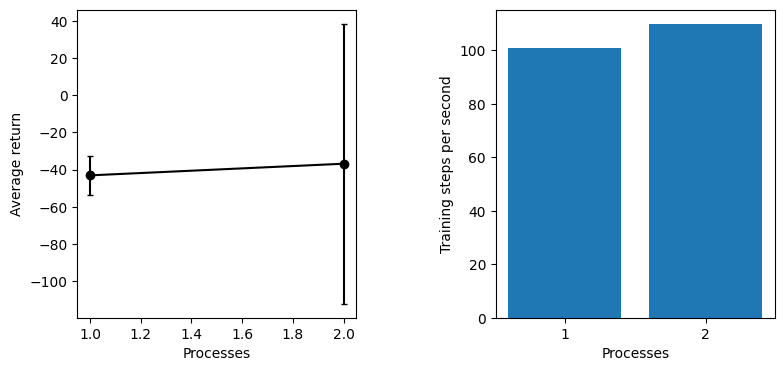

In [8]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

## Sample efficiency vs wall clock time trade-off

In [10]:

SECONDS_PER_EXPERIMENT = 10
steps_per_experiment = [int(SECONDS_PER_EXPERIMENT * fps) for fps in training_steps_per_second]
reward_averages = []
reward_std = []
training_times = []

for n_procs, train_steps in zip(PROCESSES_TO_TEST, steps_per_experiment):
    total_procs += n_procs
    print(f"Running for n_procs = {n_procs} for steps = {train_steps}")
    if n_procs == 1:
        # if there is only one process, there is no need to use multiprocessing
        train_env = DummyVecEnv([lambda: gym.make(env_id)])
    else:
        train_env = make_vec_env(env_id, n_envs=n_procs, vec_env_cls=SubprocVecEnv, vec_env_kwargs=dict(start_method='fork'))
        # Alternatively, you can use a DummyVecEnv if the communication delays is the bottleneck
        # train_env = DummyVecEnv([make_env(env_id, i+total_procs) for i in range(n_procs)])

    rewards = []
    times = []

    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=train_steps)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)

    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1 for steps = 1009
Running for n_procs = 2 for steps = 1096


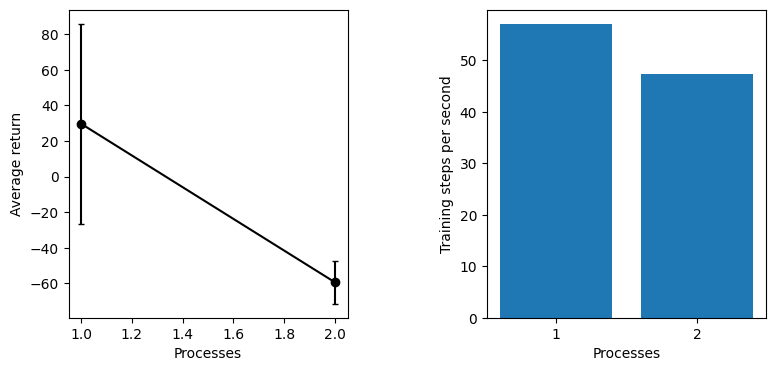

In [11]:
training_steps_per_second = [s / t for s,t in zip(steps_per_experiment, training_times)]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

## DummyVecEnv vs SubprocVecEnv

In [12]:
reward_averages = []
reward_std = []
training_times = []
total_procs = 0
for n_procs in PROCESSES_TO_TEST:
    total_procs += n_procs
    print(f'Running for n_procs = {n_procs}')
    # Here we are using only one process even for n_env > 1
    # this is equivalent to DummyVecEnv([make_env(env_id, i + total_procs) for i in range(n_procs)])
    train_env = make_vec_env(env_id, n_envs=n_procs)
    
    rewards = []
    times = []
    
    for experiment in range(NUM_EXPERIMENTS):
        # it is recommended to run several experiments due to variability in results
        train_env.reset()
        model = ALGO("MlpPolicy", train_env, verbose=0)
        start = time.time()
        model.learn(total_timesteps=TRAIN_STEPS)
        times.append(time.time() - start)
        mean_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=EVAL_EPS)
        rewards.append(mean_reward)
    
    train_env.close()
    reward_averages.append(np.mean(rewards))
    reward_std.append(np.std(rewards))
    training_times.append(np.mean(times))

Running for n_procs = 1


/opt/homebrew/Caskroom/miniconda/base/envs/ISIA/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Running for n_procs = 2


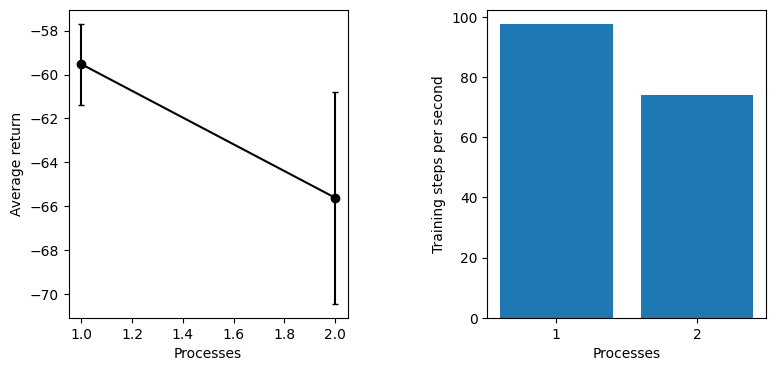

In [13]:
training_steps_per_second = [TRAIN_STEPS / t for t in training_times]

plot_training_results(training_steps_per_second, reward_averages, reward_std)

In [ ]:
model.learn(total_timesteps=int(1e5))

Now let's save it

In [ ]:
model.save("ppo_car_racing_model")

# sample an observation from the environment
obs = model.env.observation_space.sample()

# Check prediction before saving
print("pre saved", model.predict(obs, deterministic=True))

In [ ]:
del model

Load the trained agent

In [ ]:
model = PPO.load('ppo_car_racing_model.zip')
# Check that the prediction is the same after loading (for the same observation)
print("loaded", model.predict(obs, deterministic=True))

Evaluate the trained agent

In [ ]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10, deterministic=True)

print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")